In [1]:
!pip install awswrangler --quiet
#!pip install s3fs -U --quiet

In [2]:
import pandas as pd
import s3fs
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

import pyarrow as pa
import pyarrow.parquet as pq

# Especificar la ruta del archivo Parquet en el bucket de S3
s3_path = 's3://agb-prueba-bucket/Covid Data.parquet'

# Leer el archivo Parquet desde S3
covid_data = pd.read_parquet(s3fs.S3FileSystem().open(s3_path))

2024-03-21 16:08:41.148405: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-21 16:08:51.635505: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
covid_data.head(5)

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


In [4]:
covid_data.columns

Index(['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'DATE_DIED', 'INTUBED',
       'PNEUMONIA', 'AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR',
       'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY',
       'RENAL_CHRONIC', 'TOBACCO', 'CLASIFFICATION_FINAL', 'ICU'],
      dtype='object')

In [5]:
covid_data['ICU'].value_counts()

97    848544
2     175685
1      16858
99      7488
Name: ICU, dtype: int64

In [6]:
covid_data = covid_data.drop(labels=["DATE_DIED","CLASIFFICATION_FINAL"],axis=1)

covid_data.columns

Index(['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'INTUBED', 'PNEUMONIA',
       'AGE', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR',
       'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY',
       'RENAL_CHRONIC', 'TOBACCO', 'ICU'],
      dtype='object')

In [15]:
# CRITERIOS DE SELECCION DE GRAVEDAD
# GRAVE (2) SI EL PACIENTE HA SIDO INTUBADO
# MEDIA (1) SI EL PACIENTE SUFRE NEUMONÍA Y ES ASMÁTICO
# LEVE (0) EN EL RESTO DE CASOS

def severity(x):
    severity = 0

    if x["INTUBED"] == 1:
        severity = 2
    
    elif x["PNEUMONIA"] == 1 and x["ASTHMA"] == 1:
        severity = 1
        
    else:
        severity = 0
    
    return severity

sev = lambda x: severity(x)

covid_data["CLASIFFICATION_FINAL"] = covid_data.apply(sev, axis=1)

In [16]:
covid_data.head(5)

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,ICU,CLASIFFICATION_FINAL
0,2,1,1,1,97,1,65,2,2,2,2,2,1,2,2,2,2,2,97,0
1,2,1,2,1,97,1,72,97,2,2,2,2,1,2,2,1,1,2,97,0
2,2,1,2,2,1,2,55,97,1,2,2,2,2,2,2,2,2,2,2,2
3,2,1,1,1,97,2,53,2,2,2,2,2,2,2,2,2,2,2,97,0
4,2,1,2,1,97,2,68,97,1,2,2,2,1,2,2,2,2,2,97,0


In [17]:
X = covid_data.drop(labels=["CLASIFFICATION_FINAL"],axis=1)
Y = covid_data["CLASIFFICATION_FINAL"]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [19]:
np.unique(y_train)

array([0, 1, 2])

In [20]:
model = Sequential([
    Dense(64, input_shape=(len(X.columns.to_list()),), activation='relu'),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')  # Se asume que hay 3 clases (leve, media, grave)
])

In [21]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
model.fit(X_train, y_train.to_numpy(), epochs=10, batch_size=32)

Epoch 1/10


2024-03-21 16:10:20.168671: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 127506720 exceeds 10% of free system memory.


26215/26215 [==============================] - 53s 2ms/step - loss: 0.0423 - accuracy: 0.9903
Epoch 2/10
26215/26215 [==============================] - 52s 2ms/step - loss: 0.0055 - accuracy: 0.9986
Epoch 3/10
26215/26215 [==============================] - 54s 2ms/step - loss: 0.0035 - accuracy: 0.9990
Epoch 4/10
26215/26215 [==============================] - 51s 2ms/step - loss: 0.0033 - accuracy: 0.9991
Epoch 5/10
26215/26215 [==============================] - 49s 2ms/step - loss: 0.0036 - accuracy: 0.9991
Epoch 6/10
26215/26215 [==============================] - 54s 2ms/step - loss: 0.0033 - accuracy: 0.9991
Epoch 7/10
26215/26215 [==============================] - 50s 2ms/step - loss: 0.0031 - accuracy: 0.9992
Epoch 8/10
26215/26215 [==============================] - 52s 2ms/step - loss: 0.0027 - accuracy: 0.9993
Epoch 9/10
26215/26215 [==============================] - 51s 2ms/step - loss: 0.0031 - accuracy: 0.9991
Epoch 10/10
26215/26215 [==============================] - 52s 2ms

In [23]:
test_loss, test_acc = model.evaluate(X_test,  y_test.to_numpy(), verbose=0)

print('\nTest loss:', test_loss)
print('\nTest accuracy:', test_acc)

2024-03-21 16:19:21.730690: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31876680 exceeds 10% of free system memory.



Test loss: 0.0040000989101827145

Test accuracy: 0.9993658065795898


In [31]:
predictions = model.predict(X_test,verbose=0)

#Obtenemos el primer registro para ver su clasificación
pred = predictions[0]

pred = np.multiply(pred, 100)

pred = [np.format_float_positional(x, precision=2) + '%' for x in pred]

classification = np.argmax(predictions[1])


print(predictions[0]) # En formato científico
print(pred) # En formato de porcentaje

print(classification) # Label predicho

[9.9999994e-01 3.3436558e-09 5.6940089e-29]
['100.%', '0.00%', '0.00%']
0


In [32]:
#Label original
y_test.to_list()[0]

0

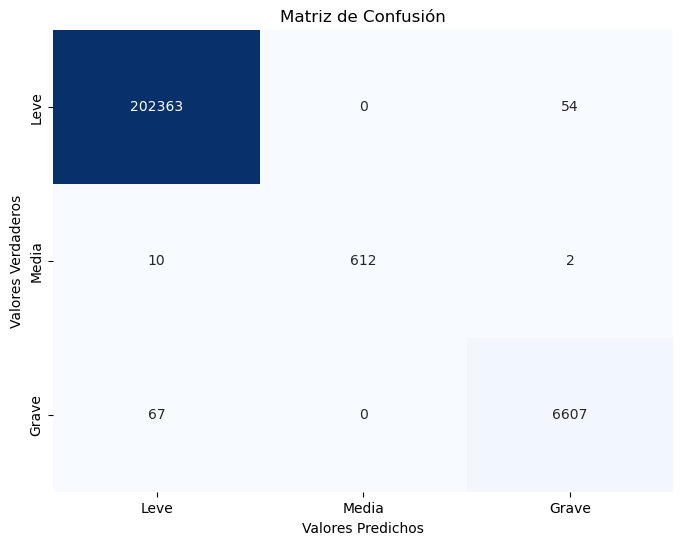

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


y_true = y_test.to_list()
y_pred = [np.argmax(x) for x in predictions]

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Leve', 'Media', 'Grave'],
            yticklabels=['Leve', 'Media', 'Grave'])

plt.title('Matriz de Confusión')
plt.xlabel('Valores Predichos')
plt.ylabel('Valores Verdaderos')
plt.show()